In [1]:
import pandas as pd
import numpy as np
import time

## Data generator

In [10]:
import requests
def bitfinex(tf, pair, start, end, limit=5000):
    url = f'https://api.bitfinex.com/v2/candles/trade:{tf}:t{pair}/hist?&start={start}&end={end}'
    request = requests.get(url)
    response = request.json()
    points = []
    if isinstance(response, list) :
        count = 0 
        for row in response:  
            json_body = {
                        "tstmp": int(row[0]),
                        "open": float(row[1]),
                        "close": float(row[2]),
                        "high": float(row[3]),
                        "low": float(row[4]),
                        "volume": float(row[5]),
                        }
            points.append(json_body)
    print('Info:    ', end, response[-1])
    return pd.DataFrame(points)

In [ ]:
tfs = ['1h', '3h', '6h', '12h']
pairs = ['NEOUSD', 'ETHUSD', 'LTCUSD']

for p in ['BTCUSD']:
    for t in tfs:
        end = 1546300800
        df = bitfinex(t, p, (end - 5000*60)*1000, (end)*1000)
        time.sleep(3)
        for i in range(1,300):
            try:
                tmp = bitfinex(t, p, (end - (i+1)*5000*60)*1000, (end - i*5000*60)*1000)
                df = pd.concat([df, tmp], ignore_index=True)
                time.sleep(7)
            except:
                pass
        df = df.drop_duplicates()
        df.to_pickle(f'{p}:{t}_full.pkl')

Info:     1546300800000 [1546002000000, 3741, 3744.5678079, 3747.1, 3729.4, 603.39720963]
Info:     1546000800000 [1545703200000, 3933.5, 3936.7, 3965.8, 3909.6, 730.78208323]
Info:     1545700800000 [1545400800000, 4159.9, 4145.2, 4179.5, 4114.8, 2242.27458336]
Info:     1545400800000 [1545102000000, 3629.4, 3670.6, 3684.4, 3627, 1184.62777255]


## Helpers

In [94]:
def make_observations(df, size: int, future: int):
    """
    Size is the number of candles used as a base for prophecy.
    Future=n sets as y the n-th price value since last know price.
    """
    assert future >0, 'Future must be >= 1'
    assert df.shape[1] == 4, 'Wrong format'
    assert df.shape[0] >= size+future+1, 'Not efficient number of records'
    assert future < size, 'Well, keep future lower than size'
    # determine how many records
    imput_thr = int(np.floor(df.shape[0]/(size+1)))
    df = df.iloc[:(size+1)*imput_thr, :] 
    df = df.values.reshape(imput_thr, size + 1, 4)
    
    output = []
    for arr in df:
        x, M, m = normalize_price(arr[:-1])
        y = (arr[-1][future-1] - m)/(M-m)
#         output.append([x.reshape(size, 4, 1), y, M, m])
        output.append([x, y, M, m])
    
    df = pd.DataFrame(output, columns=['x', 'y', 'M', 'm'])
    return df
    

def normalize_price(arr):
    M = np.max(np.max(arr))
    m = np.min(np.min(arr))
    d = M - m
    output = (arr - m)/d 
    return output, M , m

def reverse_norm(arr: np.array, M, m):
    d = M-m
    arr = d * arr + m
    return arr

                

## Import data

In [95]:
size, future = 20, 1
eth1 = pd.read_pickle('data/ETHUSD:1h_full.pkl')
eth1 = make_observations(eth1.iloc[:, :4], size, future)
eth1.head()

,x,y,M,m
0,"[[0.2607886904761901, 0.31752232142857084, 0.2...",0.805060,8.0576,7.5200
1,"[[0.3056609500682954, 0.31446349977234866, 0.1...",0.440583,8.4591,7.8002
2,"[[0.35602704593145146, 0.36721846584285356, 0....",0.186291,8.6488,7.7910
3,"[[0.7675679863639882, 0.875184008677461, 0.752...",0.058461,8.4410,7.1503
4,"[[0.32516194589101943, 0.5175917693382448, 0.2...",0.997968,7.7075,6.9202


In [96]:
eth3 = pd.read_pickle('data/ETHUSD:3h_full.pkl')
eth3 = make_observations(eth3.iloc[:, :4], size, future)
eth3.head()

,x,y,M,m
0,"[[0.1603818615751784, 0.23627684964200435, 0.1...",0.426730,153.000000,132.05
1,"[[0.7412027851261299, 0.9398555526687217, 0.64...",0.595307,147.006846,116.30
2,"[[0.20969484717948733, 0.2707692307692308, 0.1...",0.659744,163.500000,124.50
3,"[[0.9095570139458573, 1.0, 0.8904840032813781,...",0.069729,157.410000,108.65
4,"[[0.781279397930386, 0.9294449670743179, 0.733...",0.246472,122.660000,101.40


In [97]:
eth6 = pd.read_pickle('data/ETHUSD:3h_full.pkl')
eth6 = make_observations(eth6.iloc[:, :4], size, future)
eth6.head()

,x,y,M,m
0,"[[0.1603818615751784, 0.23627684964200435, 0.1...",0.426730,153.000000,132.05
1,"[[0.7412027851261299, 0.9398555526687217, 0.64...",0.595307,147.006846,116.30
2,"[[0.20969484717948733, 0.2707692307692308, 0.1...",0.659744,163.500000,124.50
3,"[[0.9095570139458573, 1.0, 0.8904840032813781,...",0.069729,157.410000,108.65
4,"[[0.781279397930386, 0.9294449670743179, 0.733...",0.246472,122.660000,101.40


In [98]:
df = pd.concat([eth1, eth3, eth6], ignore_index=True)

In [99]:
df.to_pickle(f'data/ETHUSD_pro_s={size}_f={future}.pkl')

## Models

In [4]:
from sklearn.model_selection import train_test_split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df.x.values, df.y.values, test_size=0, random_state=42)
X_train = np.array([x for x in X_train])
X_test = np.array([x for x in X_test])
X_train.shape

(2690, 20, 4)

In [101]:
size, future = 20, 1
val = pd.read_pickle('data/NEOUSD:6h_full.pkl')
val = make_observations(val.iloc[:, :4], size, future)
val.head()

,x,y,M,m
0,"[[0.2607886904761901, 0.31752232142857084, 0.2...",0.805060,8.0576,7.5200
1,"[[0.3056609500682954, 0.31446349977234866, 0.1...",0.440583,8.4591,7.8002
2,"[[0.35602704593145146, 0.36721846584285356, 0....",0.186291,8.6488,7.7910
3,"[[0.7675679863639882, 0.875184008677461, 0.752...",0.058461,8.4410,7.1503
4,"[[0.32516194589101943, 0.5175917693382448, 0.2...",0.997968,7.7075,6.9202


In [102]:
X_test = val.x.values
y_test = val.y.values
X_test = np.array([x for x in X_test])
X_test.shape

(766, 20, 4)

In [103]:
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout, Activation, Concatenate, Input, LSTM, CuDNNLSTM, concatenate, Reshape
from livelossplot.keras import PlotLossesCallback

def OHLC_prophecy(ts_input_shape,
                lstm_size = 32,
                lstm_dense = 32,
                size_dense=64,
                num_dense=2,
                p_loss='mean_squared_error',
                p_optimizer='adam',
                use_gpu_specifics=False):
    """
    Uses OHLC input
    """

    # Declare inputs
    net_input = Input(shape=(ts_input_shape, 4))
    
    # Build the ts_part of the network
    if use_gpu_specifics:
        lstm_out = CuDNNLSTM(lstm_size)(net_input)
    else:
        lstm_out= LSTM(lstm_size)(net_input)

    # Denses
    dense_out = Dense(size_dense)(lstm_out)
    for _ in range(num_dense):
        dense_out = Dense(size_dense)(dense_out)

    # Output dense
    output = Dense(1, activation='linear')(dense_out)
    
    model = Model(inputs=net_input, outputs=output)
    model.compile(loss=p_loss, optimizer=p_optimizer)

    return model

In [104]:
model = OHLC_prophecy(ts_input_shape=X_train[0].shape[0], 
                    lstm_size=200, 
                    num_dense=12,
                   )

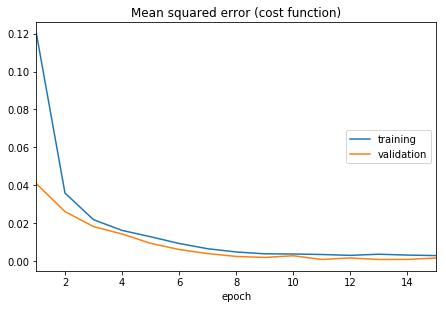

Mean squared error (cost function):
training   (min:    0.003, max:    0.120, cur:    0.003)
validation (min:    0.001, max:    0.041, cur:    0.002)


In [105]:
model.fit(
    X_train, y_train,
    epochs= 15,
    batch_size = 256,
    validation_data=(X_test, y_test),
    callbacks=[PlotLossesCallback()]
)

In [212]:
model.save('models/size20future1_110219.h5')

## Plots / tests

In [199]:
from matplotlib import pyplot as plt

class portfolio:
    def __init__(self, start_amount, model, fee=0.04):
        self.start_amount = start_amount
        self.budget = start_amount # dolars
        self.coins = 0
        self.fee = fee
        self.model = model
        self.history = []
        
    def process(self, window: pd.DataFrame):
        M = np.max(np.max(window))
        m = np.min(np.min(window))
        d = M - m
        output = (window - m)/d 
        return output, M , m

    def reshape(self, window: pd.DataFrame, size):
        return window.values.reshape(size, 4)

    def rescale(self, predicted_price, M, m):
        return  (M-m) * predicted_price + m
    
    def buy(self, price):
        self.coins = self.budget/price * (1-self.fee)
        self.market = self.coins * price
        self.budget = 0
    
    def sell(self, price):
        self.budget = self.coins * price *(1-self.fee)
        self.market = self.budget
        self.coins = 0
        
    def decide(self, price, prediction, epoch):
        if prediction >= price and self.coins==0:
            predicted_market_value = (self.budget/price * (1-self.fee)) * prediction
            if predicted_market_value >= self.market:
                self.buy(price)
                print(f'Epoch: {epoch} : BUY - actual: {price} predicted: {prediction}')
                self.history.append(('buy', price, prediction, self.coins, self.budget))
            
        if prediction < price and self.coins!=0:
#             predicted_market_value = self.coins * price * (1-self.fee)
#             if predicted_market_value >= self.market:
            self.sell(price)
            print(f'Epoch: {epoch} : SELL - actual: {price} predicted: {prediction}')
            self.history.append(('sell', price, prediction, self.coins, self.budget))
            
    def simulate(self, df: pd.DataFrame, size):
        # TODO: assert smth ! !
        y, y_hat = [], []
        self.epochs = df.shape[0]-size
        for i in range(self.epochs):
            window = df.iloc[i:i+size, :]
            recent_price = window.close.values[-1]
            
            if i==0: 
                self.buy(recent_price)
#                 print(f'First transaction - coins: {self.coins}, budget: {self.budget}')

            output, M, m = self.process(window)
            output = self.reshape(output, size)

            predicted_price = self.model.predict([[output]])[0][0]
            predicted_price = self.rescale(predicted_price, M, m)
            y.append(recent_price)
            y_hat.append(predicted_price)
            self.decide(recent_price, predicted_price, epoch=i)
#             print(f'Present status - coins: {self.coins}, budget: {self.budget}')
        
        # make last trade
        if self.coins != 0:
            self.sell(recent_price)
#             print(f'Last transaction - coins: {self.coins}, budget: {self.budget}')
    
        #  For plots
        self.y = y[1:]
        self.y_hat = y_hat
        
        self.summary()
    
    def summary(self):
        print('Portfolio summary')
        print(f'Transaction fee: {self.fee}')
        print(f'Start amount: {self.start_amount}')
        print(f'Final amount: {self.budget}')
        print(f'Earnings : {(self.budget - self.start_amount):.2f}')
        print(f'Profit : {100*(self.budget/self.start_amount -1):.2f}%')
        print(f'Decision points: {self.epochs}')
        print(f"Decisions made : {len(self.history)}, buy: {len([x for x in self.history if x[0]=='buy'])} sell: {len([x for x in self.history if x[0]=='buy'])}")
    
    def plot_history(self):
        coins = [x[3] for x in self.history if x[3]!=0]
        plt.plot(coins)
        plt.title('Coins history')
        plt.show()
        
        budget = [x[4] for x in self.history if x[4]!=0]
        plt.plot(budget)
        plt.title('Budget history')
        plt.show()
        
        

In [196]:
sample = pd.read_pickle('data/NEOUSD:6h_full.pkl')

In [215]:
port = portfolio(1000, model, fee=0.004)

In [216]:
port.simulate(sample.iloc[:200, :4], 20)

Epoch: 0 : SELL - actual: 7.944 predicted: 7.925968362426758
Epoch: 3 : BUY - actual: 7.8923 predicted: 8.086582725989818
Epoch: 5 : SELL - actual: 8.3545 predicted: 8.298089570003748
Epoch: 17 : BUY - actual: 8.2561 predicted: 8.296151679301262
Epoch: 19 : SELL - actual: 8.38983104 predicted: 8.38534643495083
Epoch: 29 : BUY - actual: 8.0077 predicted: 8.0740732301116
Epoch: 32 : SELL - actual: 8.43035993 predicted: 8.013845235916973
Epoch: 37 : BUY - actual: 7.881 predicted: 8.06714507868886
Epoch: 39 : SELL - actual: 8.161 predicted: 8.030509048885108
Epoch: 43 : BUY - actual: 7.9508 predicted: 8.096093474715948
Epoch: 46 : SELL - actual: 8.2707 predicted: 8.18288032476306
Epoch: 53 : BUY - actual: 8.112 predicted: 8.187551067906618
Epoch: 54 : SELL - actual: 8.2013 predicted: 8.009332189974188
Epoch: 55 : BUY - actual: 8.0128 predicted: 8.122705983495711
Epoch: 57 : SELL - actual: 8.2674 predicted: 8.210998999726772
Epoch: 65 : BUY - actual: 7.1762 predicted: 7.272886741557717
Epoc

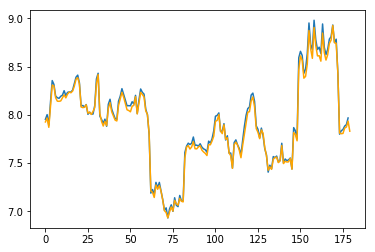

In [214]:
plt.plot(port.y)
plt.plot(port.y_hat, color='orange')
plt.show()

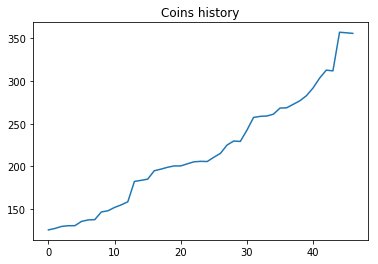

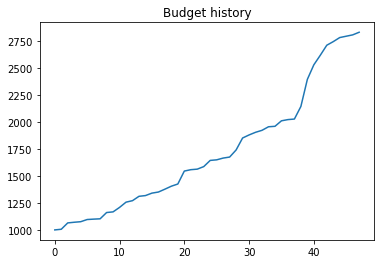

In [176]:
port.plot_history()